<a href="https://colab.research.google.com/github/muhammadanas25/Stock_trend_prediction/blob/main/Stacking_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#run
# Initial imports
import pandas as pd
!pip install path
from path import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
# Initial imports
import pandas as pd
import numpy as np
from path import Path
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn import metrics,tree
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE

from sklearn.compose import make_column_selector as selector
import matplotlib.pyplot as plt 
%pip install path
%pip install lgbm
import lightgbm as lgbm


ERROR: Could not find a version that satisfies the requirement lgbm (from versions: none)
ERROR: No matching distribution found for lgbm


In [25]:





def make_bins(df):
   label_names = ["Ef_1_v_low","Ef_1_low","Ef_1_v_med","Ef1_high", "Ef1_very_high" ]
   cut_points =ef1_cut
   df["EF_1_val"] = pd.cut(df["EF_1"], cut_points, labels=label_names)
   dummies = pd.get_dummies(df["EF_1_val"],drop_first=True)
   df = pd.concat([df, dummies], axis=1)
   label_names = ["setinent_neutral","sentiment_good","sentiment_bad"]
   cut_points =twitter_cut
   df["sentiments"]=pd.cut(df['Twitter Sentiments'], cut_points, labels=label_names)
   dummies1 = pd.get_dummies(df["sentiments"],drop_first=True)
   df = pd.concat([df, dummies1], axis=1)
   df.drop(["EF_1_val","sentiments"],axis=1,inplace=True)
   return df

def calculate_ema(prices, days, smoothing=2):
      ema = [sum(prices[:days]) / days]
      for price in prices[days:]:
          ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
      return ema

In [26]:
# Setting Index as Date
def hybrid_model(df,target):
  
  appl_df = make_bins(df)
  appl_df.head(2)
  appl_df=appl_df.drop(["Twitter Sentiments"],axis =1)
  appl_df['diff']=appl_df['Close']-appl_df['Open']
  appl_df['10day']=appl_df['Close'].rolling(10).mean()
  appl_df['10day'].fillna(appl_df['10day'][9],inplace=True)
  
  ema = calculate_ema(appl_df['Close'], 10)
  appl_df=appl_df[9:]
  target=target[9:]
  appl_df['ema']=ema
  appl_df['signal']=appl_df['ema']>appl_df['Close']
  appl_df['signal']=appl_df['signal'].replace([True,False],[1,0])

  del (appl_df['Open'])
  del (appl_df['Close'])
  del (appl_df['High'])
  del (appl_df['EF_2'])

  appl_df = appl_df.set_index("Date")

  appl_df.tail()
  new_df=appl_df

  numerical_columns_selector = selector(dtype_exclude=object)
  categorical_columns_selector = selector(dtype_include=object)
  numerical_columns = numerical_columns_selector(new_df)
  categorical_columns = categorical_columns_selector(new_df)

  print(categorical_columns)
  print(numerical_columns)
  preprocessor = ColumnTransformer([
      ('one-hot-encoder', categorical_preprocessor, categorical_columns),
      ('standard-scaler', numerical_preprocessor, numerical_columns)])
  new_df=preprocessor.fit_transform(new_df)
  
  # enc = OrdinalEncoder()
  # print(new_df.head(2))
  # standard=MinMaxScaler()
  # new_df[numerical_columns]=standard.fit_transform(  new_df[numerical_columns] )
  # new_df[categorical_columns] = enc.fit_transform(new_df[categorical_columns])
  oversample = SMOTE()
  
  new_df, target = oversample.fit_resample(new_df, target)
  

  X_train,X_test, y_train, y_test = train_test_split(new_df,target, test_size=0.2,random_state=0)
  
  new_df=pd.DataFrame(new_df)
  print(appl_df['signal'].value_counts())
  clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
  clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

  clf_rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)
  classifiers = [('svc', clf_svc),
               ('mlp', clf_mlp),                             
              #  ('nusvc', clf_nusvc),
               ('rfc', clf_rfc)]

  clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=BaggingClassifier(bootstrap= False, max_samples=0.5, n_estimators= 40,max_features=0.6
                          ,random_state=1000
                          ),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)
  
  clf.fit(X_train,y_train)
               

 
  print("Accuracy score (training): {0:.3f}".format(
          clf.score(
              X_train, 
              y_train)))
  print("Accuracy score (validation): {0:.3f}".format(
          clf.score(
              X_test, 
              y_test)))
  return clf


In [27]:
#run
# Loading data
#run
file_path = Path("IBM.csv")
df = pd.read_csv(file_path)


df.dropna(inplace=True,axis=0)
df=df[df.FutureTrend !='Neutral']
df.tail()


,Date,Open,High,Low,Close,Volume,EF_1,EF_2,Oil FutureTrend,Gold FutureTrend,Trend,Twitter Sentiments,FutureTrend
749,23/06/2021,146.429993,146.500000,144.570007,144.610001,3202600,0.020722,-1.242909,Negative,Positive,Negative,0,Negative
750,24/06/2021,145.800003,146.190002,144.690002,145.440002,3609700,0.500000,-0.246914,Negative,Negative,Negative,0,Negative
751,25/06/2021,145.380005,146.929993,144.949997,146.839996,3594200,0.954547,1.004259,Positive,Negative,Positive,0,Positive
752,28/06/2021,147.009995,147.300003,144.910004,145.289993,3888900,0.158992,-1.169989,Negative,Positive,Negative,0,Negative
753,29/06/2021,145.259995,146.740005,145.100006,145.550003,2428500,0.274388,0.199648,Negative,Negative,Positive,0,Negative


In [28]:
#run
target=df['FutureTrend']
df=df.drop("FutureTrend",axis =1)
target= target.replace(['Negative','Positive',  'Neutral'],[0,1,2])


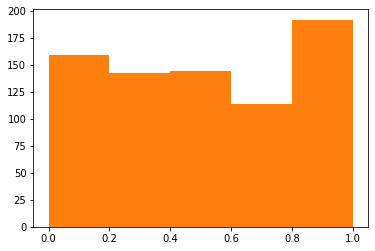

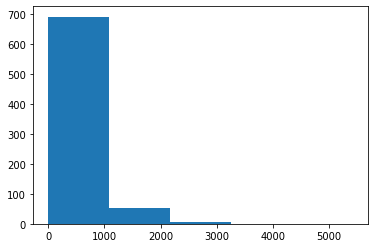

[   0.         1807.66666667 3615.33333333 5423.        ]


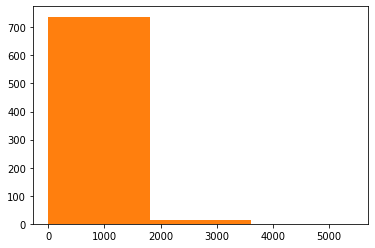

In [29]:
import matplotlib.pyplot as plt
mpgs = df['EF_1']
plt.hist(mpgs, bins=5)
ef1_cut=plt.hist(mpgs, bins=5)[1]
plt.show()
import matplotlib.pyplot as plt
mpgs = df['Twitter Sentiments']
plt.hist(mpgs, bins=5)
plt.show()
twitter_cut=plt.hist(mpgs, bins=3)[1]
print(plt.hist(mpgs, bins=3)[1]
)


In [30]:
hybrid_model(df,target)

# print("Accuracy score (training): {0:.3f}".format(
#           hyb_model.score(
#               X_train, 
#               y_train)))
# print("Accuracy score (validation): {0:.3f}".format(
#           hyb_model.score(
#               X_test, 
#               y_test)))

['Oil FutureTrend', 'Gold FutureTrend', 'Trend']
['Low', 'Volume', 'EF_1', 'Ef_1_low', 'Ef_1_v_med', 'Ef1_high', 'Ef1_very_high', 'sentiment_good', 'sentiment_bad', 'diff', '10day', 'ema', 'signal']
0    422
1    321
Name: signal, dtype: int64
Accuracy score (training): 0.689
Accuracy score (validation): 0.532


StackingClassifier(estimators=[('svc',
                                SVC(C=50, degree=1, gamma='auto',
                                    probability=True)),
                               ('mlp',
                                MLPClassifier(alpha=0.1,
                                              hidden_layer_sizes=(10, 10, 10),
                                              max_iter=2000,
                                              random_state=1000)),
                               ('rfc',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=0.005,
                                                       min_samples_split=0.005,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       random_state=1000))],
                   final_estimator=BaggingClassifier(